
# Forced Alignment with Wav2Vec2

**Author**: [Moto Hira](moto@meta.com)_

This tutorial shows how to align transcript to speech with
``torchaudio``, using CTC segmentation algorithm described in
[CTC-Segmentation of Large Corpora for German End-to-end Speech
Recognition](https://arxiv.org/abs/2007.09127)_.


In [1]:
# This is approach 3, wav2vec2 pretrained on letters not phonemes
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

2.0.1+cpu
2.0.2+cpu
cpu


## Overview

The process of alignment looks like the following.

1. Estimate the frame-wise label probability from audio waveform
2. Generate the trellis matrix which represents the probability of
   labels aligned at time step.
3. Find the most likely path from the trellis matrix.

In this example, we use ``torchaudio``\ ’s ``Wav2Vec2`` model for
acoustic feature extraction.




## Preparation

First we import the necessary packages, and fetch data that we work on.




In [4]:
# %matplotlib inline

from dataclasses import dataclass

import IPython
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams["figure.figsize"] = [16.0, 4.8]

torch.random.manual_seed(0)

# SPEECH_FILE = torchaudio.utils.download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")
SPEECH_FILE = r'C:\Users\oscar\Documents\470\JS_2023\Phoneme_Recognition\assessment_9.wav'
SPEECH_FILE = SPEECH_FILE.replace('\\', '/')
print(SPEECH_FILE)

C:/Users/oscar/Documents/470/JS_2023/Phoneme_Recognition/assessment_9.wav


## Generate frame-wise label probability

The first step is to generate the label class porbability of each aduio
frame. We can use a Wav2Vec2 model that is trained for ASR. Here we use
:py:func:`torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H`.

``torchaudio`` provides easy access to pretrained models with associated
labels.

<div class="alert alert-info"><h4>Note</h4><p>In the subsequent sections, we will compute the probability in
   log-domain to avoid numerical instability. For this purpose, we
   normalize the ``emission`` with :py:func:`torch.log_softmax`.</p></div>




In [5]:
import torchaudio.transforms as T

bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
model = bundle.get_model().to(device)
labels = bundle.get_labels()
desired_sample_rate = 16000
with torch.inference_mode():
    waveform, sample_rate = torchaudio.load(SPEECH_FILE)
    if sample_rate != desired_sample_rate:
        resampler = T.Resample(sample_rate, desired_sample_rate, dtype=waveform.dtype)
        waveform = resampler(waveform)
        sample_rate = desired_sample_rate
    emissions, _ = model(waveform.to(device))
    emissions = torch.log_softmax(emissions, dim=-1)

emission = emissions[0].cpu().detach()

In [6]:
print(emission.shape)
print(sample_rate)

# play audio
IPython.display.Audio(data=waveform[0].cpu().numpy(), rate=sample_rate)

torch.Size([693, 29])
16000


### Visualization



('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


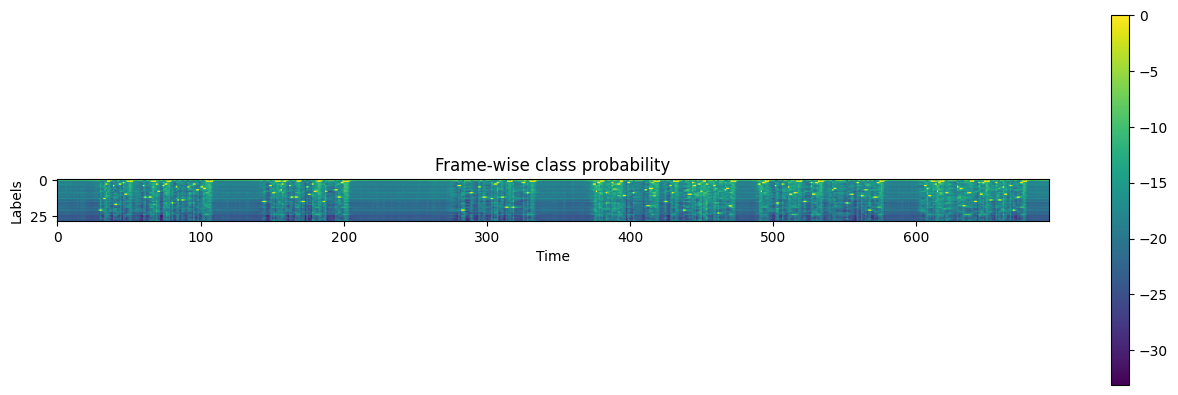

In [7]:
print(labels)
plt.imshow(emission.T)
plt.colorbar()
plt.title("Frame-wise class probability")
plt.xlabel("Time")
plt.ylabel("Labels")
plt.show()

In [10]:
print(labels)

('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


## Generate alignment probability (trellis)

From the emission matrix, next we generate the trellis which represents
the probability of transcript labels occur at each time frame.

Trellis is 2D matrix with time axis and label axis. The label axis
represents the transcript that we are aligning. In the following, we use
$t$ to denote the index in time axis and $j$ to denote the
index in label axis. $c_j$ represents the label at label index
$j$.

To generate, the probability of time step $t+1$, we look at the
trellis from time step $t$ and emission at time step $t+1$.
There are two path to reach to time step $t+1$ with label
$c_{j+1}$. The first one is the case where the label was
$c_{j+1}$ at $t$ and there was no label change from
$t$ to $t+1$. The other case is where the label was
$c_j$ at $t$ and it transitioned to the next label
$c_{j+1}$ at $t+1$.

The follwoing diagram illustrates this transition.

<img src="https://download.pytorch.org/torchaudio/tutorial-assets/ctc-forward.png">

Since we are looking for the most likely transitions, we take the more
likely path for the value of $k_{(t+1, j+1)}$, that is

$k_{(t+1, j+1)} = max( k_{(t, j)} p(t+1, c_{j+1}), k_{(t, j+1)} p(t+1, repeat) )$

where $k$ represents is trellis matrix, and $p(t, c_j)$
represents the probability of label $c_j$ at time step $t$.
$repeat$ represents the blank token from CTC formulation. (For the
detail of CTC algorithm, please refer to the *Sequence Modeling with CTC*
[[distill.pub](https://distill.pub/2017/ctc/)_])




In [49]:
# transcript = "I|HAD|THAT|CURIOSITY|BESIDE|ME|AT|THIS|MOMENT"
transcript = "But after all that commotion, was it all worthwhile? Absolutely yes! The set design was breathtaking, the actors were incredible, and the songs were memorable."

def format_transcript(transcript):
    import string
    translator = str.maketrans('', '', string.punctuation)
    cleaned_string = transcript.translate(translator)
    words = cleaned_string.split()
    # Convert each word to uppercase and join them with '|'
    result_string = '|'.join(word.upper() for word in words)
    return result_string

transcript = format_transcript(transcript)
print(f"Transcript: {transcript}")

dictionary = {c: i for i, c in enumerate(labels)}

tokens = [dictionary[c] for c in transcript]
print(list(zip(transcript, tokens)))


def get_trellis(emission, tokens, blank_id=0):
    num_frame = emission.size(0)
    num_tokens = len(tokens)

    # Trellis has extra diemsions for both time axis and tokens.
    # The extra dim for tokens represents <SoS> (start-of-sentence)
    # The extra dim for time axis is for simplification of the code.
    trellis = torch.empty((num_frame + 1, num_tokens + 1))
    trellis[0, 0] = 0
    trellis[1:, 0] = torch.cumsum(emission[:, 0], 0)
    trellis[0, -num_tokens:] = -float("inf")
    trellis[-num_tokens:, 0] = float("inf")

    for t in range(num_frame):
        trellis[t + 1, 1:] = torch.maximum(
            # Score for staying at the same token
            trellis[t, 1:] + emission[t, blank_id],
            # Score for changing to the next token
            trellis[t, :-1] + emission[t, tokens],
        )
    return trellis


trellis = get_trellis(emission, tokens)

Transcript: BUT|AFTER|ALL|THAT|COMMOTION|WAS|IT|ALL|WORTHWHILE|ABSOLUTELY|YES|THE|SET|DESIGN|WAS|BREATHTAKING|THE|ACTORS|WERE|INCREDIBLE|AND|THE|SONGS|WERE|MEMORABLE
[('B', 21), ('U', 13), ('T', 3), ('|', 1), ('A', 4), ('F', 17), ('T', 3), ('E', 2), ('R', 10), ('|', 1), ('A', 4), ('L', 12), ('L', 12), ('|', 1), ('T', 3), ('H', 8), ('A', 4), ('T', 3), ('|', 1), ('C', 16), ('O', 5), ('M', 14), ('M', 14), ('O', 5), ('T', 3), ('I', 7), ('O', 5), ('N', 6), ('|', 1), ('W', 15), ('A', 4), ('S', 9), ('|', 1), ('I', 7), ('T', 3), ('|', 1), ('A', 4), ('L', 12), ('L', 12), ('|', 1), ('W', 15), ('O', 5), ('R', 10), ('T', 3), ('H', 8), ('W', 15), ('H', 8), ('I', 7), ('L', 12), ('E', 2), ('|', 1), ('A', 4), ('B', 21), ('S', 9), ('O', 5), ('L', 12), ('U', 13), ('T', 3), ('E', 2), ('L', 12), ('Y', 19), ('|', 1), ('Y', 19), ('E', 2), ('S', 9), ('|', 1), ('T', 3), ('H', 8), ('E', 2), ('|', 1), ('S', 9), ('E', 2), ('T', 3), ('|', 1), ('D', 11), ('E', 2), ('S', 9), ('I', 7), ('G', 18), ('N', 6), ('|', 1),

### Visualization



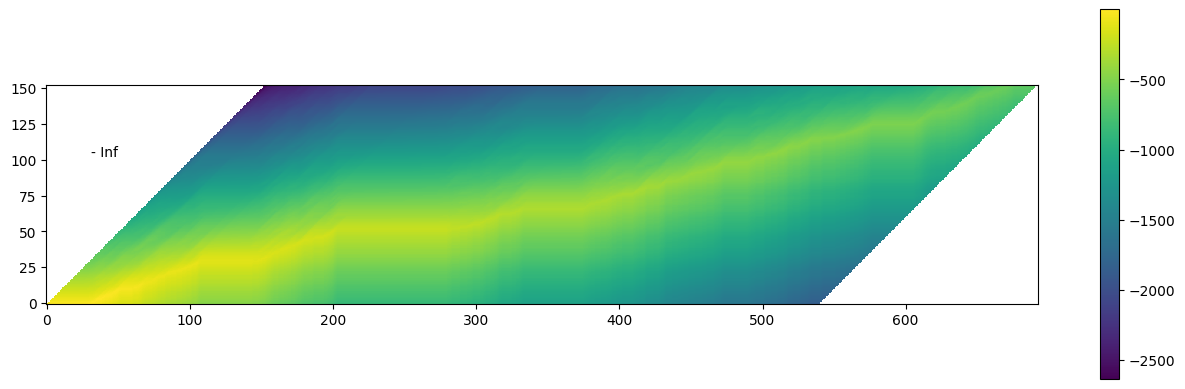

In [50]:
plt.imshow(trellis[1:, 1:].T, origin="lower")
plt.annotate("- Inf", (trellis.size(1) / 5, trellis.size(1) / 1.5))
plt.colorbar()
plt.show()

In the above visualization, we can see that there is a trace of high
probability crossing the matrix diagonally.




## Find the most likely path (backtracking)

Once the trellis is generated, we will traverse it following the
elements with high probability.

We will start from the last label index with the time step of highest
probability, then, we traverse back in time, picking stay
($c_j \rightarrow c_j$) or transition
($c_j \rightarrow c_{j+1}$), based on the post-transition
probability $k_{t, j} p(t+1, c_{j+1})$ or
$k_{t, j+1} p(t+1, repeat)$.

Transition is done once the label reaches the beginning.

The trellis matrix is used for path-finding, but for the final
probability of each segment, we take the frame-wise probability from
emission matrix.




In [51]:
@dataclass
class Point:
    token_index: int
    time_index: int
    score: float


def backtrack(trellis, emission, tokens, blank_id=0):
    # Note:
    # j and t are indices for trellis, which has extra dimensions
    # for time and tokens at the beginning.
    # When referring to time frame index `T` in trellis,
    # the corresponding index in emission is `T-1`.
    # Similarly, when referring to token index `J` in trellis,
    # the corresponding index in transcript is `J-1`.
    j = trellis.size(1) - 1
    t_start = torch.argmax(trellis[:, j]).item()

    path = []
    for t in range(t_start, 0, -1):
        # 1. Figure out if the current position was stay or change
        # Note (again):
        # `emission[J-1]` is the emission at time frame `J` of trellis dimension.
        # Score for token staying the same from time frame J-1 to T.
        stayed = trellis[t - 1, j] + emission[t - 1, blank_id]
        # Score for token changing from C-1 at T-1 to J at T.
        changed = trellis[t - 1, j - 1] + emission[t - 1, tokens[j - 1]]

        # 2. Store the path with frame-wise probability.
        prob = emission[t - 1, tokens[j - 1] if changed > stayed else 0].exp().item()
        # Return token index and time index in non-trellis coordinate.
        path.append(Point(j - 1, t - 1, prob))

        # 3. Update the token
        if changed > stayed:
            j -= 1
            if j == 0:
                break
    else:
        raise ValueError("Failed to align")
    return path[::-1]


path = backtrack(trellis, emission, tokens)
for p in path:
    print(p)

Point(token_index=0, time_index=30, score=0.999871015548706)
Point(token_index=0, time_index=31, score=0.9998574256896973)
Point(token_index=0, time_index=32, score=0.9943087697029114)
Point(token_index=1, time_index=33, score=0.9998869895935059)
Point(token_index=2, time_index=34, score=0.9998800754547119)
Point(token_index=2, time_index=35, score=0.0033480776473879814)
Point(token_index=3, time_index=36, score=0.9997040629386902)
Point(token_index=3, time_index=37, score=0.9999892711639404)
Point(token_index=3, time_index=38, score=0.9999998807907104)
Point(token_index=4, time_index=39, score=0.9999967813491821)
Point(token_index=4, time_index=40, score=0.012184008955955505)
Point(token_index=5, time_index=41, score=0.9999916553497314)
Point(token_index=5, time_index=42, score=0.9999974966049194)
Point(token_index=5, time_index=43, score=0.050845079123973846)
Point(token_index=6, time_index=44, score=0.9999849796295166)
Point(token_index=6, time_index=45, score=0.999984622001648)
Poi

### Visualization



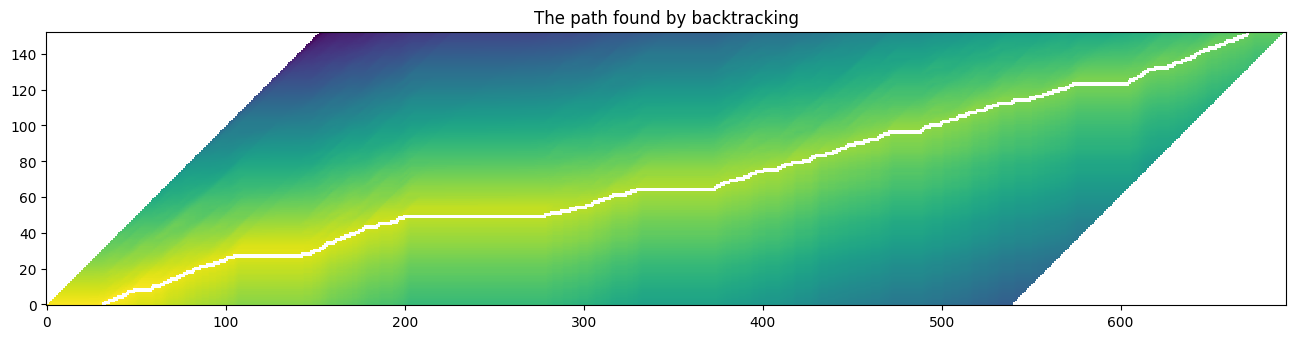

In [52]:
def plot_trellis_with_path(trellis, path):
    # To plot trellis with path, we take advantage of 'nan' value
    trellis_with_path = trellis.clone()
    for _, p in enumerate(path):
        trellis_with_path[p.time_index, p.token_index] = float("nan")
    plt.imshow(trellis_with_path[1:, 1:].T, origin="lower")


plot_trellis_with_path(trellis, path)
plt.title("The path found by backtracking")
plt.show()

Looking good. Now this path contains repetations for the same labels, so
let’s merge them to make it close to the original transcript.

When merging the multiple path points, we simply take the average
probability for the merged segments.




In [242]:
# Merge the labels
@dataclass
class Segment:
    label: str
    start: int
    end: int
    score: float

    def __repr__(self):
        return f"{self.label}\t({self.score:4.2f}): [{self.start:5d}, {self.end:5d})"

    @property
    def length(self):
        return self.end - self.start


def merge_repeats(path):
    i1, i2 = 0, 0
    segments = []
    while i1 < len(path):
        while i2 < len(path) and path[i1].token_index == path[i2].token_index:
            i2 += 1
        score = sum(path[k].score for k in range(i1, i2)) / (i2 - i1)
        segments.append(
            Segment(
                transcript[path[i1].token_index],
                path[i1].time_index,
                path[i2 - 1].time_index + 1,
                score,
            )
        )
        i1 = i2
    return segments


segments = merge_repeats(path)
for seg in segments:
    print(seg)

B	(1.00): [   30,    33)
U	(1.00): [   33,    34)
T	(0.50): [   34,    36)
|	(1.00): [   36,    39)
A	(0.51): [   39,    41)
F	(0.68): [   41,    44)
T	(1.00): [   44,    46)
E	(1.00): [   46,    47)
R	(0.35): [   47,    50)
|	(0.81): [   50,    60)
A	(1.00): [   60,    61)
L	(0.75): [   61,    65)
L	(0.50): [   65,    67)
|	(0.50): [   67,    69)
T	(0.55): [   69,    71)
H	(1.00): [   71,    74)
A	(0.54): [   74,    76)
T	(0.50): [   76,    78)
|	(0.99): [   78,    80)
C	(1.00): [   80,    83)
O	(1.00): [   83,    84)
M	(1.00): [   84,    87)
M	(1.00): [   87,    91)
O	(1.00): [   91,    95)
T	(0.67): [   95,    98)
I	(0.95): [   98,   101)
O	(1.00): [  101,   102)
N	(0.64): [  102,   106)
|	(0.95): [  106,   144)
W	(0.74): [  144,   149)
A	(0.97): [  149,   151)
S	(0.66): [  151,   154)
|	(0.50): [  154,   156)
I	(1.00): [  156,   157)
T	(1.00): [  157,   158)
|	(0.75): [  158,   162)
A	(1.00): [  162,   163)
L	(0.91): [  163,   166)
L	(0.65): [  166,   168)
|	(0.67): [  168,   171)


### Visualization



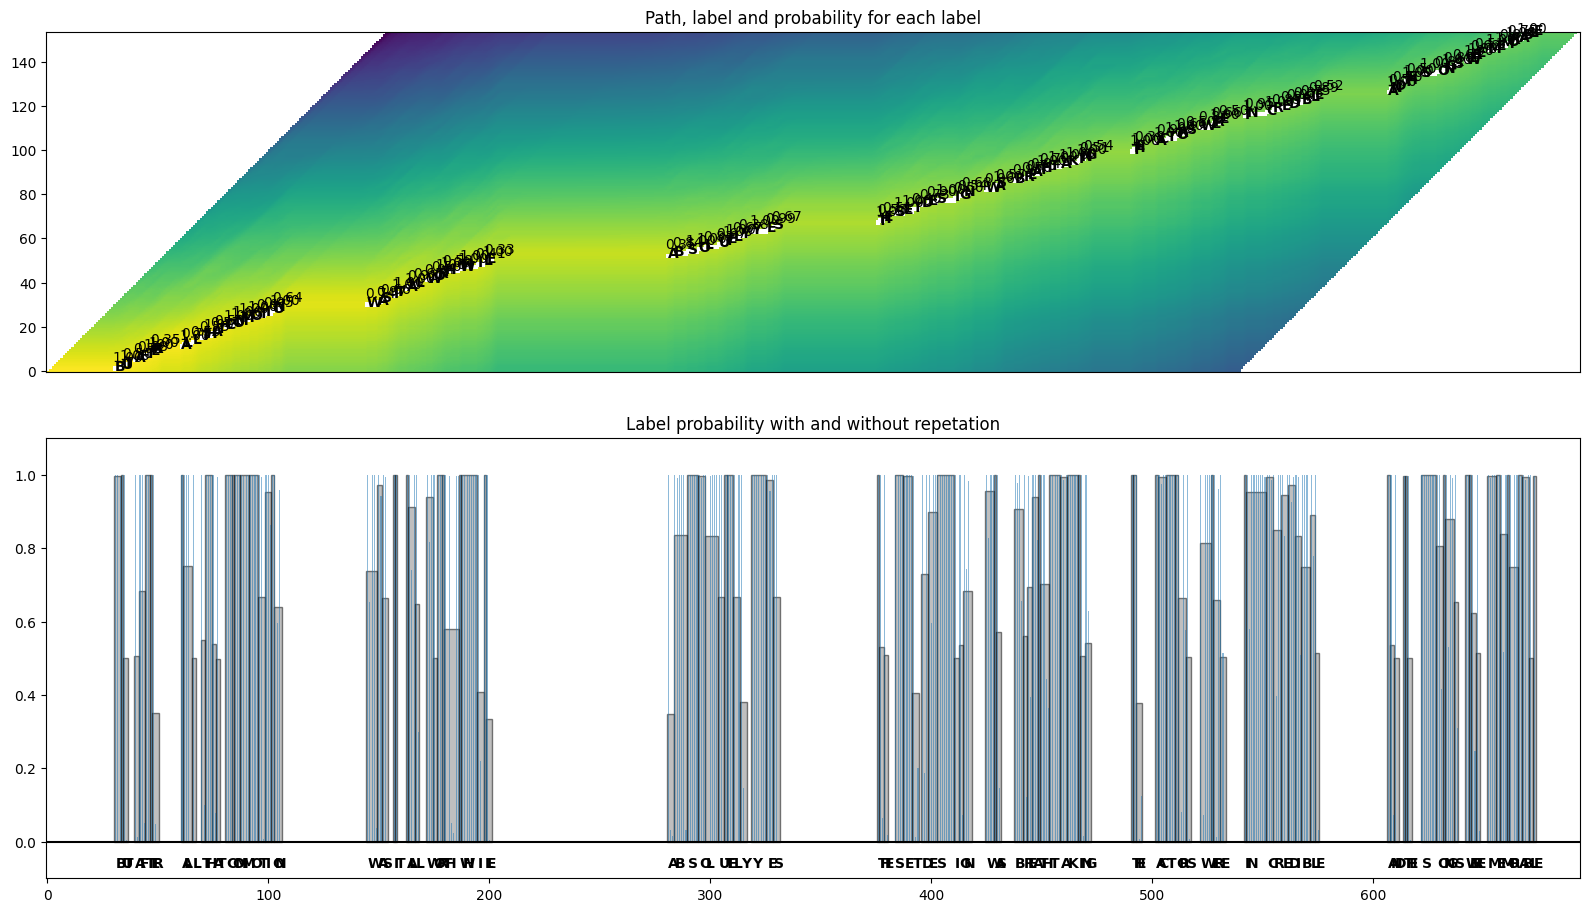

In [196]:
def plot_trellis_with_segments(trellis, segments, transcript):
    # To plot trellis with path, we take advantage of 'nan' value
    trellis_with_path = trellis.clone()
    for i, seg in enumerate(segments):
        if seg.label != "|":
            trellis_with_path[seg.start + 1 : seg.end + 1, i + 1] = float("nan")

    fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 9.5))
    ax1.set_title("Path, label and probability for each label")
    ax1.imshow(trellis_with_path.T, origin="lower")
    ax1.set_xticks([])

    for i, seg in enumerate(segments):
        if seg.label != "|":
            ax1.annotate(seg.label, (seg.start + 0.7, i + 0.3), weight="bold")
            ax1.annotate(f"{seg.score:.2f}", (seg.start - 0.3, i + 4.3))

    ax2.set_title("Label probability with and without repetation")
    xs, hs, ws = [], [], []
    for seg in segments:
        if seg.label != "|":
            xs.append((seg.end + seg.start) / 2 + 0.4)
            hs.append(seg.score)
            ws.append(seg.end - seg.start)
            ax2.annotate(seg.label, (seg.start + 0.8, -0.07), weight="bold")
    ax2.bar(xs, hs, width=ws, color="gray", alpha=0.5, edgecolor="black")

    xs, hs = [], []
    for p in path:
        label = transcript[p.token_index]
        if label != "|":
            xs.append(p.time_index + 1)
            hs.append(p.score)

    ax2.bar(xs, hs, width=0.5, alpha=0.5)
    ax2.axhline(0, color="black")
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_ylim(-0.1, 1.1)


plot_trellis_with_segments(trellis, segments, transcript)
plt.tight_layout()
plt.show()

In [243]:
# First, let's see if the phonemes match the 40 phoneme CMU set and clean up the grapheme to phoneme dictionary

# this won't work for cases where one letter maps to multiple phonemes, for example POS is pronounced Pee Oh Es, "P|IY1","OW1","EH1|S" but this can be mitigated somewhat by splitting the timestamps into equal parts for each 2-phone combination.

# Read g2p.json into a dict
g2p_path = "./cmudict/g2p.json"
import json
import re
with open(g2p_path, "r") as f:
    g2p = json.load(f)

to_remove = []

unique_phonemes = set()
for key in g2p:
    # print(g2p[key]['phonemes'])
    if not any("foreign" in element for element in g2p[key]['phonemes']) and not any("#" in element for element in g2p[key]['phonemes']) and not any("old" in element for element in g2p[key]['phonemes']):
      for phoneme in g2p[key]['phonemes']:
        for individual_phoneme in phoneme.split('|'):
            unique_phonemes.add(re.sub(r'\d+', '', individual_phoneme))
    else:
      to_remove.append(key)

for key in to_remove:
    del g2p[key]

# print(unique_phonemes)

# Read CMU Phonemes into a list

CMU_phonemes_path = "./cmudict/SphinxPhones_40.txt"
CMU_phonemes = set()
with open(CMU_phonemes_path, "r") as f:
    for line in f:
        CMU_phonemes.add(line.strip())

print(f"The following phonemes are in CMU but not in g2p: {CMU_phonemes.difference(unique_phonemes)}")
print(f"The following phonemes are in g2p but not in CMU: {unique_phonemes.difference(CMU_phonemes)}")



The following phonemes are in CMU but not in g2p: {'SIL'}
The following phonemes are in g2p but not in CMU: {'_'}


Looks good. Now let’s merge the words. The Wav2Vec2 model uses ``'|'``
as the word boundary, so we merge the segments before each occurance of
``'|'``.

Then, finally, we segment the original audio into segmented audio and
listen to them to see if the segmentation is correct.




In [244]:
# Merge words
def merge_words(segments, separator="|"):
    words = []
    i1, i2 = 0, 0
    while i1 < len(segments):
        if i2 >= len(segments) or segments[i2].label == separator:
            if i1 != i2:
                segs = segments[i1:i2]
                word = "".join([seg.label for seg in segs])
                score = sum(seg.score * seg.length for seg in segs) / sum(seg.length for seg in segs)
                words.append(Segment(word, segments[i1].start, segments[i2 - 1].end, score))
            i1 = i2 + 1
            i2 = i1
        else:
            i2 += 1
    return words


word_segments = merge_words(segments)
for word in word_segments:
    print(word)

BUT	(0.83): [   30,    36)
AFTER	(0.65): [   39,    50)
ALL	(0.71): [   60,    67)
THAT	(0.69): [   69,    78)
COMMOTION	(0.90): [   80,   106)
WAS	(0.76): [  144,   154)
IT	(1.00): [  156,   158)
ALL	(0.84): [  162,   168)
WORTHWHILE	(0.74): [  171,   201)
ABSOLUTELY	(0.78): [  280,   316)
YES	(0.92): [  318,   331)
THE	(0.62): [  375,   380)
SET	(0.84): [  383,   394)
DESIGN	(0.81): [  395,   418)
WAS	(0.85): [  424,   431)
BREATHTAKING	(0.84): [  437,   472)
THE	(0.63): [  490,   495)
ACTORS	(0.85): [  501,   517)
WERE	(0.71): [  521,   533)
INCREDIBLE	(0.88): [  541,   575)
AND	(0.61): [  606,   611)
THE	(0.75): [  613,   617)
SONGS	(0.90): [  621,   638)
WERE	(0.75): [  641,   648)
MEMORABLE	(0.89): [  651,   673)


In [245]:
# Add phoneme boundaries
# merge phonemes

segment_index = 0
segments.append(Segment("|", segments[-1].end, segments[-1].end, 1.0)) # add a word separator at the end
for word in word_segments:
    print(f"Scanning word {word.label}")
    phonemes_map = g2p[word.label.lower()]
    for idx, grapheme in enumerate(phonemes_map['graphemes']):
        if "|" not in grapheme:
            if grapheme != segments[segment_index].label.lower():
                print(f"Error: {grapheme} != {segments[segment_index].label}")
                break
            segments[segment_index].label = phonemes_map['phonemes'][idx]
            segment_index += 1

            if segments[segment_index].label == "|":
                print(f"Found word separator after {word.label}")
                segment_index += 1
            else:
                print(f"Adding phoneme separator after {segments[segment_index-1].label}")
                segments.insert(segment_index, Segment("|", segments[segment_index-1].end, segments[segment_index].start, 1.0))
                segment_index += 1

            # print(segments)
        else:
            print(f"Found 2 letter phoneme {grapheme}")
            for idx2, letter in enumerate(grapheme.split("|")):               
                segments[segment_index].label = phonemes_map['phonemes'][idx]
                print(f"Letter {idx2}: {letter}. Segment: {segments[segment_index].label}")
                segment_index += 1
                # if segments[segment_index].label == "|":
                #     print("Error: found a word separator in the middle of a phoneme")
                #     print(segments[:segment_index])
                #     break
            if segments[segment_index].label != "|":
                print(f"Adding phoneme separator after {segments[segment_index-1].label}")
                segments.insert(segment_index, Segment("|", segments[segment_index-1].end, segments[segment_index].start, 1.0))
                segment_index += 1
            else:
                print(f"Found word separator after {word.label}")
                segment_index += 1

# remove silent phonemes
segments = [segment for segment in segments if segment.label != "_"]

# print(segments[-5:])
# mitigate double phonemes by splitting them evenly, this is an approximation which introduces small errors
split_segments = []
import numpy as np
for segment in segments:
    if segment.label == "|":
        split_segments.append(segment)
        continue
    phonemes = segment.label.split("|")
    num_parts = len(phonemes)
    if num_parts > 1:
        print(f"Found {num_parts} phonemes in {segment.label}")
        parts = np.linspace(segment.start, segment.end, num_parts + 1, dtype=int)
        for idx, phoneme in enumerate(phonemes):
            split_segments.append(Segment(phoneme, parts[idx], parts[idx+1], segment.score))
            split_segments.append(Segment("|", parts[idx+1], parts[idx+1], 1.0))
    else:
        split_segments.append(segment)

while split_segments[-1].label == "|":
    print(f"Removing trailing word separator at {split_segments[-1].start}")
    split_segments = split_segments[:-1] # remove last "|" segment

# print(split_segments[-5:])



Scanning word BUT
Adding phoneme separator after B
Adding phoneme separator after AH1
Found word separator after BUT
Scanning word AFTER
Adding phoneme separator after AE1
Adding phoneme separator after F
Adding phoneme separator after T
Found 2 letter phoneme e|r
Letter 0: e. Segment: ER0
Letter 1: r. Segment: ER0
Found word separator after AFTER
Scanning word ALL
Adding phoneme separator after AO1
Found 2 letter phoneme l|l
Letter 0: l. Segment: L
Letter 1: l. Segment: L
Found word separator after ALL
Scanning word THAT
Found 2 letter phoneme t|h
Letter 0: t. Segment: DH
Letter 1: h. Segment: DH
Adding phoneme separator after DH
Adding phoneme separator after AH0
Found word separator after THAT
Scanning word COMMOTION
Adding phoneme separator after K
Adding phoneme separator after AH0
Found 2 letter phoneme m|m
Letter 0: m. Segment: M
Letter 1: m. Segment: M
Adding phoneme separator after M
Adding phoneme separator after OW1
Found 2 letter phoneme t|i
Letter 0: t. Segment: SH
Letter 

In [246]:
# Merge phonemes
def merge_phonemes(segments, separator="|"):
    words = []
    i1, i2 = 0, 0
    while i1 < len(segments):
        if i2 >= len(segments) or segments[i2].label == separator:
            if i1 != i2:
                segs = segments[i1:i2]
                if all(seg.label == segs[0].label for seg in segs):
                    word = segs[0].label
                else:
                    word = "".join([seg.label for seg in segs])
                score = sum(seg.score * seg.length for seg in segs) / sum(seg.length for seg in segs)
                words.append(Segment(word, segments[i1].start, segments[i2 - 1].end, score))
            i1 = i2 + 1
            i2 = i1
        else:
            i2 += 1
    return words

phoneme_segments = merge_phonemes(split_segments)
for phoneme in phoneme_segments:
    print(phoneme)

B	(1.00): [   30,    33)
AH1	(1.00): [   33,    34)
T	(0.50): [   34,    36)
AE1	(0.51): [   39,    41)
F	(0.68): [   41,    44)
T	(1.00): [   44,    46)
ER0	(0.51): [   46,    50)
AO1	(1.00): [   60,    61)
L	(0.67): [   61,    67)
DH	(0.82): [   69,    74)
AH0	(0.54): [   74,    76)
T	(0.50): [   76,    78)
K	(1.00): [   80,    83)
AH0	(1.00): [   83,    84)
M	(1.00): [   84,    91)
OW1	(1.00): [   91,    95)
SH	(0.81): [   95,   101)
AH0	(1.00): [  101,   102)
N	(0.64): [  102,   106)
W	(0.74): [  144,   149)
AH0	(0.97): [  149,   151)
Z	(0.66): [  151,   154)
IH0	(1.00): [  156,   157)
T	(1.00): [  157,   158)
AO1	(1.00): [  162,   163)
L	(0.81): [  163,   168)
W	(0.94): [  171,   174)
ER1	(0.75): [  174,   178)
TH	(0.63): [  178,   186)
W	(1.00): [  186,   187)
AY1	(0.41): [  194,   197)
L	(1.00): [  197,   198)
AE2	(0.35): [  280,   283)
B	(0.84): [  283,   289)
S	(1.00): [  289,   294)
AH0	(1.00): [  294,   297)
L	(0.83): [  297,   303)
UW1	(0.67): [  303,   306)
T	(1.00): [  30

In [248]:
for seg in segments:
    print(seg)

B	(1.00): [   30,    33)
|	(1.00): [   33,    33)
AH1	(1.00): [   33,    34)
|	(1.00): [   34,    34)
T	(0.50): [   34,    36)
|	(1.00): [   36,    39)
AE1	(0.51): [   39,    41)
|	(1.00): [   41,    41)
F	(0.68): [   41,    44)
|	(1.00): [   44,    44)
T	(1.00): [   44,    46)
|	(1.00): [   46,    46)
ER0	(1.00): [   46,    47)
ER0	(0.35): [   47,    50)
|	(0.81): [   50,    60)
AO1	(1.00): [   60,    61)
|	(1.00): [   61,    61)
L	(0.75): [   61,    65)
L	(0.50): [   65,    67)
|	(0.50): [   67,    69)
DH	(0.55): [   69,    71)
DH	(1.00): [   71,    74)
|	(1.00): [   74,    74)
AH0	(0.54): [   74,    76)
|	(1.00): [   76,    76)
T	(0.50): [   76,    78)
|	(0.99): [   78,    80)
K	(1.00): [   80,    83)
|	(1.00): [   83,    83)
AH0	(1.00): [   83,    84)
|	(1.00): [   84,    84)
M	(1.00): [   84,    87)
M	(1.00): [   87,    91)
|	(1.00): [   91,    91)
OW1	(1.00): [   91,    95)
|	(1.00): [   95,    95)
SH	(0.67): [   95,    98)
SH	(0.95): [   98,   101)
|	(1.00): [  101,   101)
AH0	(

### Visualization



In [203]:
def plot_alignments(trellis, segments, word_segments, waveform):
    trellis_with_path = trellis.clone()
    for i, seg in enumerate(segments):
        if seg.label != "|":
            trellis_with_path[seg.start + 1 : seg.end + 1, i + 1] = float("nan")

    fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 9.5))

    ax1.imshow(trellis_with_path[1:, 1:].T, origin="lower")
    ax1.set_xticks([])
    ax1.set_yticks([])

    for word in word_segments:
        ax1.axvline(word.start - 0.5)
        ax1.axvline(word.end - 0.5)

    for i, seg in enumerate(segments):
        if seg.label != "|":
            ax1.annotate(seg.label, (seg.start, i + 0.3))
            ax1.annotate(f"{seg.score:.2f}", (seg.start, i + 4), fontsize=8)

    # The original waveform
    ratio = waveform.size(0) / (trellis.size(0) - 1)
    ax2.plot(waveform)
    for word in word_segments:
        x0 = ratio * word.start
        x1 = ratio * word.end
        ax2.axvspan(x0, x1, alpha=0.1, color="red")
        ax2.annotate(f"{word.score:.2f}", (x0, 0.8))

    for seg in segments:
        if seg.label != "|":
            ax2.annotate(seg.label, (seg.start * ratio, 0.9))
    xticks = ax2.get_xticks()
    plt.xticks(xticks, xticks / sample_rate)
    ax2.set_xlabel("time [second]")
    ax2.set_yticks([])
    ax2.set_ylim(-1.0, 1.0)
    ax2.set_xlim(0, waveform.size(-1))


plot_alignments(
    trellis,
    segments,
    word_segments,
    waveform[0],
)
plt.show()

IndexError: index 154 is out of bounds for dimension 1 with size 154

In [249]:
# A trick to embed the resulting audio to the generated file.
# `IPython.display.Audio` has to be the last call in a cell,
# and there should be only one call par cell.
def display_segment(segments,i):
    ratio = waveform.size(1) / (trellis.size(0) - 1)
    phoneme = segments[i]
    x0 = int(ratio * phoneme.start)
    x1 = int(ratio * phoneme.end)
    print(f"{phoneme.label} ({phoneme.score:.2f}): {x0 / sample_rate:.3f} - {x1 / sample_rate:.3f} sec")
    segment = waveform[:, x0:x1]
    return IPython.display.Audio(segment.numpy(), rate=sample_rate)

In [250]:
# Generate the audio for each segment
print(transcript)
IPython.display.Audio(SPEECH_FILE)

BUT|AFTER|ALL|THAT|COMMOTION|WAS|IT|ALL|WORTHWHILE|ABSOLUTELY|YES|THE|SET|DESIGN|WAS|BREATHTAKING|THE|ACTORS|WERE|INCREDIBLE|AND|THE|SONGS|WERE|MEMORABLE


In [251]:
display_segment(phoneme_segments, 0)

B (1.00): 0.600 - 0.660 sec


In [252]:
display_segment(phoneme_segments, 1)

AH1 (1.00): 0.660 - 0.680 sec


In [253]:
display_segment(phoneme_segments, 2)

T (0.50): 0.680 - 0.721 sec


In [254]:
display_segment(phoneme_segments, 3)

AE1 (0.51): 0.781 - 0.821 sec


In [255]:
display_segment(phoneme_segments, 4)

F (0.68): 0.821 - 0.881 sec


In [256]:
display_segment(phoneme_segments, 5)

T (1.00): 0.881 - 0.921 sec


In [257]:
display_segment(phoneme_segments, 6)

ER0 (0.51): 0.921 - 1.001 sec


In [258]:
display_segment(phoneme_segments, 7)

AO1 (1.00): 1.201 - 1.221 sec


In [270]:
display_segment(phoneme_segments, 68)

AE1 (1.00): 10.028 - 10.048 sec


## Conclusion

In this tutorial, we looked how to use torchaudio’s Wav2Vec2 model to
perform CTC segmentation for forced alignment.


